In [1]:
import SimpleITK as sitk
import os
import numpy as np
from tqdm import tqdm

In [2]:
def read_image(path: str):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(path)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    return sitk.GetArrayFromImage(itkimage)

In [3]:
img_files = list(os.scandir(r'C:\Users\Roel\Documents\scan_cropped4'))

In [4]:
img = read_image(img_files[0].path)

In [44]:
from typing import List, Tuple

# Adapted from https://stackoverflow.com/questions/10460337/how-to-generate-calculate-vertices-of-dodecahedron/10462220
def make_dodecahedron(r: float):
    phi = (5 ** 0.5 - 1) / 2
    a = 1 / 3**0.5
    b = a / phi
    c = a * phi
    
    vertices: List[Tuple[float, float, float]] = []
    
    for i in [-1 , 1]:
        for j in [-1, 1]:
            vertices.append((
                0, 
                i * c * r, 
                j * b * r
            ))
            vertices.append((
                i * c * r, 
                j * b * r, 
                0
            ))
            vertices.append((
                i * b * r, 
                0, 
                j * c * r
            ))
            
            for k in [-1, 1]:
                vertices.append((
                    i * a * r, 
                    j * a * r, 
                    k * a * r
                ))
    return vertices

In [45]:
vertices = make_dodecahedron(1)

In [157]:
v_normed = -np.array(vertices[3]) / np.linalg.norm(vertices[0])
up = np.array([-1, 0, 0])
cross = np.cross(up, v_normed)
cross = cross / np.linalg.norm(cross)
corrected_up = np.cross(v_normed, cross)
corrected_up = corrected_up / np.linalg.norm(corrected_up)
space = np.stack([corrected_up, v_normed, cross]).T

In [158]:
from scipy.ndimage import affine_transform

In [227]:
import math
def length(v):
    return math.sqrt(v[0]*v[0]+v[1]*v[1]+v[2]*v[2])

def normalize(v):
    l = length(v)
    return [v[0]/l, v[1]/l, v[2]/l]

def dot(v0, v1):
    return v0[0]*v1[0]+v0[1]*v1[1]+v0[2]*v1[2]

def cross(v0, v1):
    return [
        v0[1]*v1[2]-v1[1]*v0[2],
        v0[2]*v1[0]-v1[2]*v0[0],
        v0[0]*v1[1]-v1[0]*v0[1]]

def m3dLookAt(eye, target, up):
    mz = normalize( (eye[0]-target[0], eye[1]-target[1], eye[2]-target[2]) ) # inverse line of sight
    mx = normalize( cross( up, mz ) )
    my = normalize( cross( mz, mx ) )
    tx =  dot( mx, eye )
    ty =  dot( my, eye )
    tz = dot( mz, eye )   
    return np.array([mx[0], my[0], mz[0], 0, mx[1], my[1], mz[1], 0, mx[2], my[2], mz[2], 0, tx, ty, tz, 1])

In [260]:
def normalize(v):
    return v / np.linalg.norm(v)

# Adapted from https://www.geertarien.com/blog/2017/07/30/breakdown-of-the-lookAt-function-in-OpenGL/
def look_at(eye, at, up):
    zaxis = normalize(at - eye)
    xaxis = normalize(np.cross(zaxis, up))
    yaxis = np.cross(xaxis, zaxis)

    zaxis = -zaxis
    
    viewMatrix = np.array([
        [xaxis[0], xaxis[1], xaxis[2], -np.dot(xaxis, eye)],
        [yaxis[0], yaxis[1], yaxis[2], -np.dot(yaxis, eye)],
        [zaxis[0], zaxis[1], zaxis[2], -np.dot(zaxis, eye)],
        [0, 0, 0, 1]
    ])

    return viewMatrix

In [ ]:
direction = -vertices[3]
yaw = atan

In [269]:
def perspective(field_of_view_y, aspect, z_near, z_far):

    fov_radians = math.radians(field_of_view_y)
    f = math.tan(fov_radians/2)

    a_11 = 1/(f*aspect)
    a_22 = 1/f
    a_33 = -(z_near + z_far)/(z_near - z_far)
    a_34 = -2*z_near*z_far/(z_near - z_far)

    # a_33 = -(z_far + z_near)/(z_far - z_near)
    # a_34 = 2*z_far*z_near/(z_far - z_near)

    perspective_matrix = np.array([
        [a_11, 0, 0, 0],       
        [0, a_22, 0, 0],       
        [0, 0, a_33, a_34],    
        [0, 0, -1, 0]          
    ]).T 

    return perspective_matrix

# projection_matrix = perspective(45, 600/480, 0.1, 400)
# mvp_matrix = projection_matrix * view_matrix * model_matrix

In [272]:
 perspective(45, 600/480, 0.1, 400).T

array([[ 1.93137085,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  2.41421356,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.00050013,  0.20005001],
       [ 0.        ,  0.        , -1.        ,  0.        ]])

In [271]:
%matplotlib inline
ax = fig.add_subplot(111)
# space = m3dLookAt(np.array([0, 0, 1])*np.array(img.shape)+np.array(img.shape)/2, np.array(img.shape)/2, np.array([1, 0, 0]))
space = perspective(45, 600/480, 0.1, 400).T @ look_at(np.array(img.shape)*4, np.array(img.shape)/2, np.array([1, 0, 0]))

# center = np.array(img.shape)/2
# center_out = center*2
# rot = np.linalg.inv(space)
# offset = (center - center@rot) @ np.linalg.inv(rot)
# offset = center @ (rot)
plt.imshow(np.mean(affine_transform(img, np.linalg.inv(space)), axis=0))

c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


ValueError: Expected homogeneous transformation matrix with shape (4, 4) for image shape (284, 207, 311), but bottom row was not equal to [0, 0, 0, 1]

In [301]:
angles = []
for i in range(12):
    angles.append((np.random.random()*np.pi*2, np.random.random()*np.pi*2, np.random.random()*np.pi*2))

In [334]:
from numpy import sin, cos
def rot_and_proj3d(img, agg, a, b, g, order=1):
    T = np.array([
        [1, 0, 0, img.shape[0]/2], 
        [0, 1, 0, img.shape[1]/2], 
        [0, 0, 1, img.shape[2]/2], 
        [0, 0, 0, 1]
    ])
    T = T @ np.array([[ cos(b)*cos(g), (sin(a)*sin(b)*cos(g) + cos(a)*sin(g)), (sin(a)*sin(g) - cos(a)*sin(b)*cos(g)), 0],
                  [-cos(b)*sin(g), (cos(a)*cos(g) - sin(a)*sin(b)*sin(g)), (sin(a)*cos(g) + cos(a)*sin(b)*sin(g)), 0],
                  [        sin(b), -sin(a)*cos(b), cos(a)*cos(b), 0], 
                  [ 0, 0, 0, 1]])
    T = T @ np.array([
        [1, 0, 0, -img.shape[0]*0.65], 
        [0, 1, 0, -img.shape[1]*0.65], 
        [0, 0, 1, -img.shape[2]*0.65], 
        [0, 0, 0, 1]
    ])
    return agg(affine_transform(img, T, order=order, output_shape=(np.array(img.shape)*1.3).astype(int)), axis=0)
#     return agg(affine_transform(img, T, order=order, output=output_image), axis=0)

In [326]:
output_image = np.zeros((np.array(img.shape)*1.25).astype(int), dtype=np.float32)

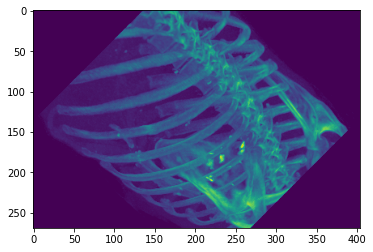

In [335]:
plt.imshow(rot_and_proj3d(img, np.max, np.pi/4, np.pi/3, np.pi/2))

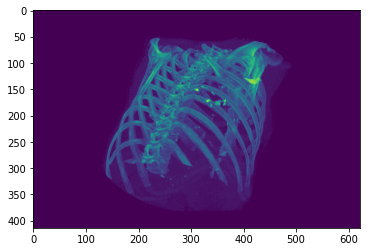

In [300]:

plt.imshow(np.max(affine_transform(img, T, output_shape=np.array(img.shape)*2), axis=0))

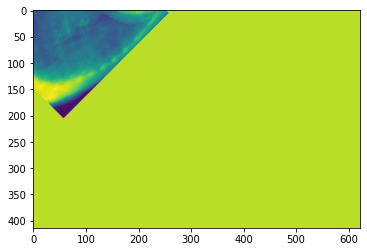

In [288]:
from numpy import sin, cos
a, b, g = np.pi/4, np.pi/2, 0

T = np.array([
    [1, 0, 0, img.shape[0]/2], 
    [0, 1, 0, 100+img.shape[1]/2], 
    [0, 0, 1, img.shape[2]/2], 
    [0, 0, 0, 1]
])
T = T @ np.array([[ cos(b)*cos(g), (sin(a)*sin(b)*cos(g) + cos(a)*sin(g)), (sin(a)*sin(g) - cos(a)*sin(b)*cos(g)), 0],
              [-cos(b)*sin(g), (cos(a)*cos(g) - sin(a)*sin(b)*sin(g)), (sin(a)*cos(g) + cos(a)*sin(b)*sin(g)), 0],
              [        sin(b), -sin(a)*cos(b), cos(a)*cos(b), 0], 
              [ 0, 0, 0, 1]])
T = T @ np.array([
    [1, 0, 0, -img.shape[0]/2], 
    [0, 1, 0, -img.shape[1]/2], 
    [0, 0, 1, -img.shape[2]/2], 
    [0, 0, 0, 1]
])
plt.imshow(np.mean(affine_transform(img, T, output_shape=np.array(img.shape)*2), axis=0))

In [287]:
np.array([0, 0, 1])*np.array(img.shape)/2+np.array(img.shape)/2

array([142. , 103.5, 311. ])

In [231]:
img.shape

(284, 207, 311)

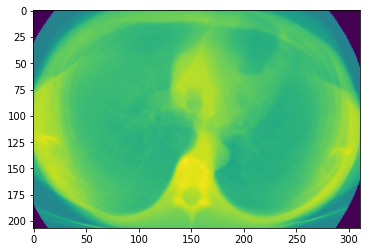

In [246]:
plt.imshow(np.mean(img, axis=0))

In [208]:
transform = space.reshape(4, 4).T
transform

array([[ 0.00000000e+00,  8.32461869e-01, -5.54082337e-01,
         0.00000000e+00],
       [ 7.96089221e-01, -3.35319146e-01, -5.03788668e-01,
        -1.42108547e-14],
       [-6.05179272e-01, -4.41098977e-01, -6.62713921e-01,
         9.91710466e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [81]:
np.dot(cross, corrected_up)

0.0

In [78]:
%matplotlib ipympl
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver([0]*2, [0]*2, [0]*2, *zip(*[up]))
ax.quiver([0]*1, [0]*1, [0]*1, *zip(*[v_normed]), color='g')

ax.quiver([0]*1, [0]*1, [0]*1, *zip(*[crs]), color='r')
ax.quiver([0]*1, [0]*1, [0]*1, *zip(*[corrected_up]), color='pink')


ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

plt.zlim([-1, 1])

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: module 'matplotlib.pyplot' has no attribute 'zlim'

In [41]:
 %matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [42]:
from scipy.spatial import ConvexHull
hull = ConvexHull(vertices)

In [43]:

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
# ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(np.array(vertices)[s, 0], np.array(vertices)[s, 1], np.array(vertices)[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [49]:
%matplotlib ipympl
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*zip(*vertices))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
def get_slabs(img: np.ndarray, axis: int, n_slabs: int, slab_size, agg_func=np.mean):
    size = img.shape[axis]
    if isinstance(slab_size, float):
        slab_size = int(slab_size * size)
    full_slices = [slice(img.shape[d]) for d in range(3)]
    slabs = []
    for i in range(n_slabs):
        slab_pos = int(size*0.75/(n_slabs-1)*i+0.125*size)
        slab_start = np.clip(slab_pos - slab_size//2, 0, size)
        slab_end = np.clip(slab_pos + slab_size//2, 0, size)
        slices = full_slices.copy()
        slices[axis] = slice(int(slab_start), int(slab_end)+1)
        if agg_func != np.average:
            slab = agg_func(img[tuple(slices)], axis=axis)
        else:
            kernel = np.zeros((int(slab_end - slab_start + 1), ))
            kernel[int(slab_pos-slab_start)] = 1
#             if i == 10:
#                 print(slab_size, slab_start, slab_end)
#                 plt.plot(kernel)
#                 plt.show()
            kernel = gaussian_filter1d(kernel, sigma=2.8)
#             if i == 10:
#                 plt.plot(kernel)
#                 plt.show()
            slab = agg_func(img[tuple(slices)], axis=axis, weights=kernel)
        slabs.append(slab)
    return slabs

In [25]:
import matplotlib.pyplot as plt
def plot_slabs(slabs):
    for slab in slabs:
        plt.imshow(slab)
        plt.show()

In [26]:
from scipy.ndimage import gaussian_filter1d

In [27]:
slabs = get_slabs(img, 0, 30, 1/28, agg_func=np.mean)

In [28]:
img.dtype

dtype('int16')

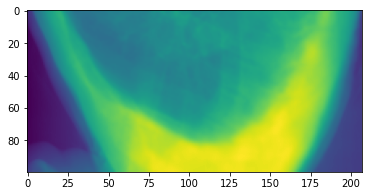

In [38]:
plt.imshow(np.mean(img[-100:, :, :], axis=2))

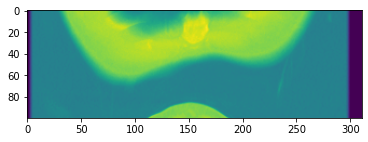

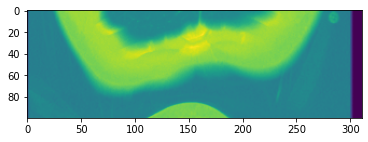

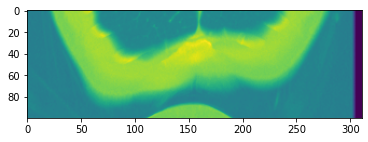

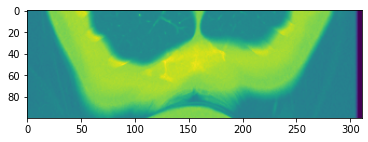

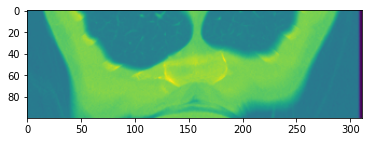

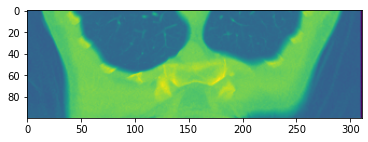

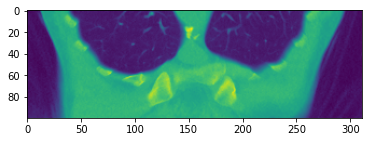

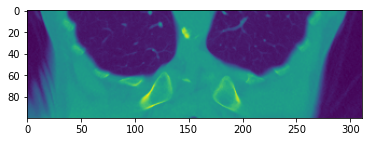

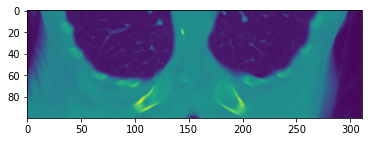

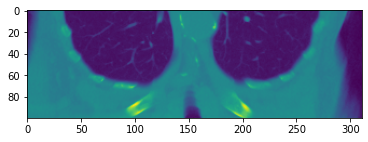

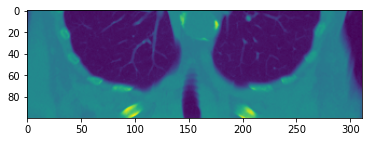

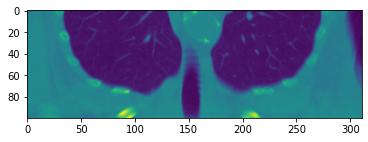

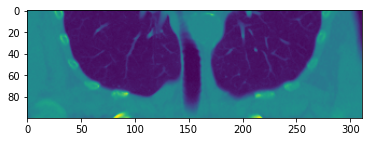

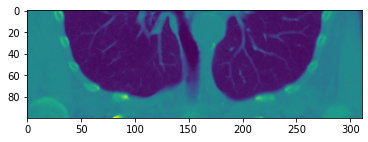

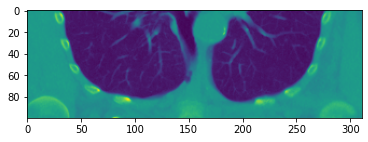

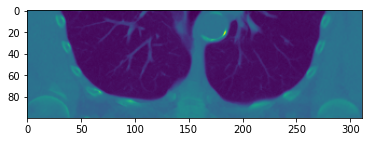

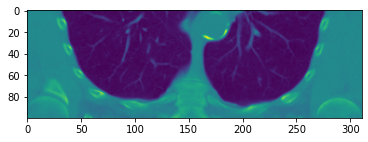

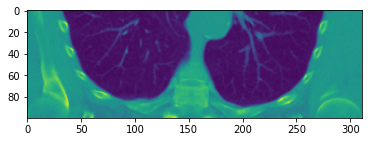

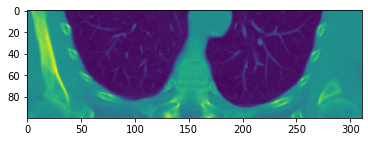

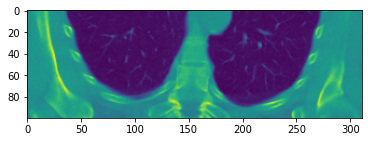

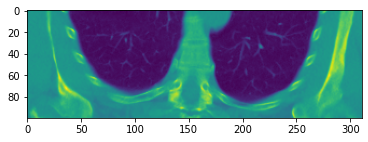

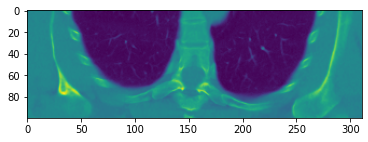

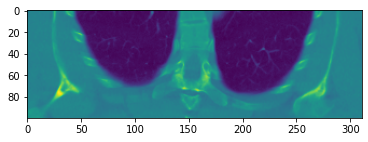

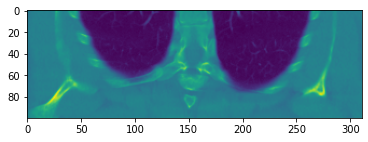

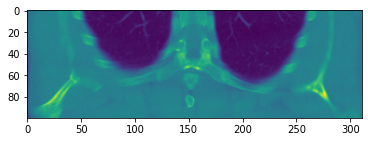

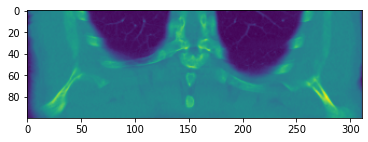

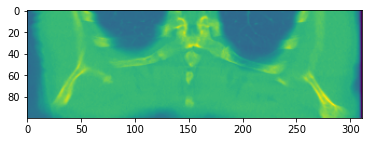

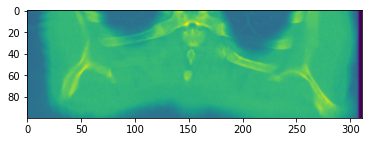

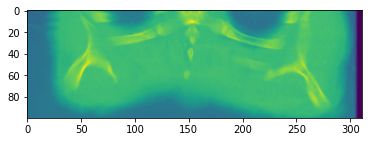

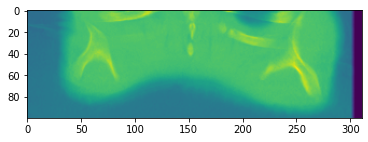

In [31]:
plot_slabs(get_slabs(img[-100:, :, :], 1, 30, 1/28, agg_func=np.mean))

In [26]:
agg_funcs = [np.mean, np.median, np.max, np.average]
axes = [0, 1, 2]

In [306]:
from tifffile import imwrite

In [28]:
!mkdir slab_images

A subdirectory or file slab_images already exists.


In [29]:
def normalize(img):
    normed = (img - img.min()) / (img.max() - img.min()) * 255
    return np.stack([normed]*3, axis=2).astype(np.uint8)

In [304]:
!mkdir randproj_images

In [ ]:
for img_file in tqdm(img_files):
    img = read_image(img_file.path)
    for angle_ind, angle in enumerate(angles):
        for agg_func in [np.max, np.mean]:
            proj = rot_and_proj3d(img, agg_func, *angle)
            imwrite(f'randproj_images/{os.path.splitext(img_file.name)[0]}_{angle_ind}_{agg_func.__name__}.tif', normalize(proj))

 28%|████████████████████████▉                                                               | 286/1009 [13:00:54<11:04:34, 55.15s/it]

In [94]:
os.path.splitext(img_files[0].name)[0]

'10351_st000'

In [106]:
agg_funcs[2].__name__

'amax'

In [20]:
import tifffile

In [ ]:
tifffile.TiffWriter()